In [187]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertModel, CamembertTokenizer, AdamW
import os
from tqdm import tqdm
from dotenv import load_dotenv
import numpy as np
import pandas as pd 
import random

In [188]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [189]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
RECORD_IDS_TRAINING_SET = PARENT + os.getenv("RECORD_IDS_TRAINING_SET")

In [190]:
generated_captions = pd.read_csv("../CSV/subset_generated_captions.csv")
generated_captions

,recordID,question,caption_EN,caption_FR
0,3959,caption,A white vase with green leaves sits on a wood...,Un vase blanc aux feuilles vertes se trouve su...
1,3959,What is a short caption for this image where y...,A white vase with green leaves sits on a dark...,Un vase blanc aux feuilles vertes se trouve su...
2,3959,What is a short caption for this image where y...,A white vase with green leaves sits on a dark...,Un vase blanc aux feuilles vertes se trouve su...
3,3959,What is a short caption for this image where y...,A white vase with green leaves sits on a dark...,Un vase blanc aux feuilles vertes se trouve su...
4,3959,What is a short caption for this image where y...,A white vase with green leaves sits on a dark...,Un vase blanc aux feuilles vertes se trouve su...
...,...,...,...,...
12160,5498,caption,"A man in a blue robe lies on the ground, whil...","Un homme en robe bleue se trouve sur le sol, t..."
12161,5498,What is a short caption for this image where y...,"A man in a blue robe lies on the ground, whil...","Un homme en robe bleue se trouve sur le sol, t..."
12162,5498,What is a short caption for this image where y...,"A man in a blue robe lies on the ground, whil...","Un homme en robe bleue se trouve sur le sol, t..."
12163,5498,What is a short caption for this image where y...,"A man in a blue robe sits on a rock, illumina...",Un homme en robe bleue est assis sur un rocher...


In [191]:
# Define your custom dataset
class HardFilterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        texts: List of French texts.
        labels: List of label lists. For example, if you have 4 hard filters,
                each label might be a list of 4 binary values.
        tokenizer: A pretrained tokenizer (e.g., CamembertTokenizer).
        max_length: Maximum sequence length.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze the extra batch dimension
        item = {key: encoding[key].squeeze(0) for key in encoding}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [192]:
# Load Camembert tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [193]:
HARD_FILTERS = [
    {
        "type": "CENTURY",
        "content": [1701, 1800]
    },
    {
        "type": "CENTURY",
        "content": [1801, 1900]
    },
    {
        "type": "CENTURY",
        "content": [1901, 2000]
    },
    {
        "type": "CENTURY",
        "content": [2001, 2100]
    },
    {
        "type": "CANVAS_TYPE",
        "content": "peinture"
    },
    {
        "type": "CANVAS_TYPE",
        "content": "sculpture"
    },
    {
        "type": "CANVAS_TYPE",
        "content": "dessin"
    }
]

def generate_synthetic_date():
    # Get a random caption
    caption = generated_captions.sample().iloc[0]["caption_FR"]

    hasAdd = random.choice([True, False])
    if not hasAdd:
        return caption, np.zeros(len(HARD_FILTERS))
    
    FILTER_INDEX = np.random.randint(0, len(HARD_FILTERS))
    FILTER = HARD_FILTERS[FILTER_INDEX]

    # Add the filter
    if FILTER["type"] == "CENTURY":

        methods = [0,1]
        method = np.random.choice(methods)
        start, end = FILTER["content"]
        add = None

        if method == 0:
            # "18ème siècle"
            if start == 1701:
                add = "18ème siècle"
            elif start == 1801:
                add = "19ème siècle"
            elif start == 1901:
                add = "20ème siècle"
            elif start == 2001:
                add = "21ème siècle"
        elif method == 1:
            # "1765"
            year = np.random.randint(start, end)
            add = str(year)

        caption += " " + add
    elif FILTER["type"] == "CANVAS_TYPE":
        add = FILTER["content"]

    FILTER_ARRAY = np.zeros(len(HARD_FILTERS))
    FILTER_ARRAY[FILTER_INDEX] = 1
    return add, FILTER_ARRAY

generate_synthetic_date()

('19ème siècle', array([0., 1., 0., 0., 0., 0., 0.]))

In [194]:
def generate_N_synthetic_dates(N):
    captions = []
    GT = []
    for _ in tqdm(range(N)):
        caption, filter_array = generate_synthetic_date()
        captions.append(caption)
        GT.append(filter_array)
    return captions, GT

In [195]:
N = 50000
texts, labels = generate_N_synthetic_dates(N)

100%|██████████| 50000/50000 [00:17<00:00, 2823.82it/s]


In [196]:
encoder = CamembertModel.from_pretrained('camembert-base')
# Put the encoder on the same device as the data
encoder.to(device)
dimension_encoder = encoder.config.hidden_size
print(f"Encoder dimension: {dimension_encoder}")

Encoder dimension: 768


In [197]:
def encode(dataloader):
    # Store the sentence embeddings in this list
    embeddings = []
    # Store the labels in this list
    labels = []

    # No need to compute gradients
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Get the sentence embeddings
            outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
            # Use the representation of the first token (<s>) as the sentence embedding.
            pooled_output = outputs.last_hidden_state[:, 0, :]
            embeddings.append(pooled_output.cpu().numpy())
            labels.append(batch['labels'].cpu().numpy())

    # Concatenate the results to get a single numpy array
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    return embeddings, labels

In [198]:
# Create dataset and dataloader
dataset_text = HardFilterDataset(texts, labels, tokenizer, max_length=77)
dataloader_text = DataLoader(dataset_text, batch_size=128, shuffle=True)
# Encode the text
embeddings, labels = encode(dataloader_text)
print(embeddings.shape, labels.shape)

100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


(50000, 768) (50000, 7)


In [199]:
# Create training and testing sets
N = len(embeddings)
N_train = int(0.8 * N)
N_test = N - N_train
indices = np.random.permutation(N)
indices_train = indices[:N_train]
indices_test = indices[N_train:]
X_train = embeddings[indices_train]
y_train = labels[indices_train]
X_test = embeddings[indices_test]
y_test = labels[indices_test]

print(f"Training set size: {N_train}")
print(f"Testing set size: {N_test}")

Training set size: 40000
Testing set size: 10000


In [200]:
# Create dataset and dataloader
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    
    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
dataset_embeddings_training = EmbeddingsDataset(X_train, y_train)
dataloader_embeddings_training = DataLoader(dataset_embeddings_training, batch_size=128, shuffle=True)

dataset_embeddings_testing = EmbeddingsDataset(X_test, y_test)
dataloader_embeddings_testing = DataLoader(dataset_embeddings_testing, batch_size=128, shuffle=False)

print(f"Training set size: {len(dataset_embeddings_training)}")
print(f"Testing set size: {len(dataset_embeddings_testing)}")

Training set size: 40000
Testing set size: 10000


In [201]:
# Create the model
class HardFilterClassifier(nn.Module):
    def __init__(self, num_labels):
        """
        num_labels: Number of hard filters.
        """
        super(HardFilterClassifier, self).__init__()
        self.l1 = nn.Linear(dimension_encoder, dimension_encoder//2)
        self.l2 = nn.Linear(dimension_encoder//2, num_labels)

    def forward(self, embeddings):
        x = self.l1(embeddings)
        x = nn.ReLU()(x)
        x = self.l2(x)
        return nn.Sigmoid()(x)

In [202]:
# Initialize the classifier: here we assume 4 hard filters.
num_filters = len(HARD_FILTERS)
model = HardFilterClassifier(num_labels=num_filters)
# Put on the device
model.to(device)
model

HardFilterClassifier(
  (l1): Linear(in_features=768, out_features=384, bias=True)
  (l2): Linear(in_features=384, out_features=7, bias=True)
)

Epoch 100, loss: 0.8233: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


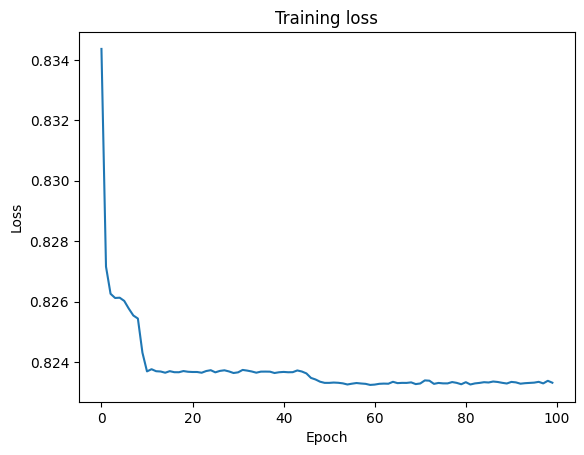

In [203]:
# Use ADAM
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Apply sigmoid for probability
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice  # Minimize loss

loss_fn = DiceLoss()

losses = []


# Training loop (basic example)
model.train()
num_epochs = 100
tqdm_bar = tqdm(range(num_epochs))
for epoch in tqdm_bar:
    epoch_loss = 0.0
    for batchIndex, batch in enumerate(dataloader_embeddings_training):
        b_embeddings, b_labels = batch
        b_embeddings = b_embeddings.to(device)
        b_labels = b_labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Get predictions
        predictions = model(b_embeddings)
        # Compute the loss
        loss = loss_fn(predictions, b_labels)
        # Backpropagate
        loss.backward()
        # Optimize
        optimizer.step()
        epoch_loss += loss.item()

    # Change the description of the tqdm bar
    epoch_loss = float(epoch_loss)/len(dataloader_embeddings_training)
    tqdm_bar.set_description(f"Epoch {epoch+1}, loss: {epoch_loss:.4f}")
    losses.append(epoch_loss)

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

In [206]:
def evaluate(model, dataloader, threshold=0.25):
    # Measure the precision and recall
    TP, FP, TN, FN = 0, 0, 0, 0
    # No need to compute gradients
    with torch.no_grad():
        for batch in dataloader:
            embeddings, labels = batch
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            # Get predictions
            predictions = model(embeddings)
            # Apply threshold
            predictions = (predictions > threshold).float()
            # Compute the confusion matrix
            TP += ((predictions == 1) & (labels == 1)).sum().item()
            FP += ((predictions == 1) & (labels == 0)).sum().item()
            TN += ((predictions == 0) & (labels == 0)).sum().item()
            FN += ((predictions == 0) & (labels == 1)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    
    return accuracy, precision, recall

# Evaluate the model
model.eval()
train_accuracy, train_precision, train_recall = evaluate(model, dataloader_embeddings_training)
test_accuracy, test_precision, test_recall = evaluate(model, dataloader_embeddings_testing)

print(f"Train accuracy: {train_accuracy:.4f}, precision: {train_precision:.4f}, recall: {train_recall:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}, precision: {test_precision:.4f}, recall: {test_recall:.4f}")

Train accuracy: 0.9646, precision: 0.6689, recall: 1.0000
Test accuracy: 0.9651, precision: 0.6684, recall: 1.0000


In [207]:
def infer(text):
    # Encode the text
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=77,
        return_tensors='pt'
    )

    # Use the model
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        predictions = model(pooled_output)

    return predictions.cpu().numpy()

# Test the inference
text = "Des peintures entre 1890 et 1910"
predictions = infer(text)

# Print the predictions
for i, prediction in enumerate(predictions[0]):
    filter = HARD_FILTERS[i]
    filterName = filter["type"] + " " + str(filter["content"])
    print(f"{filterName}: {prediction:.4f}")

CENTURY [1701, 1800]: 0.0000
CENTURY [1801, 1900]: 0.0000
CENTURY [1901, 2000]: 0.0000
CENTURY [2001, 2100]: 0.0000
CANVAS_TYPE peinture: 0.0008
CANVAS_TYPE sculpture: 0.0000
CANVAS_TYPE dessin: 0.0000
